# 4.2. Transcriptomics-Metabolomics
Pairwise integration and alignment were performed on the multi-omics mouse cerebellum dataset, specifically between the PLATO spatial proteomics and MALDI-MSI spatial metabolomics consecutive slices.

 The MAGIC-seq slice captured 1,677 spatial spots at a resolution of 32 μm, profiling 16,116 genes. The MALDI-MSI slice offers higher spatial resolution, capturing 3,908 spots with 491 metabolite peaks.
## Preparation

In [1]:
import sys
import time
from spatialFuser import *
import scanpy as sc
import pandas as pd
import numpy as np
sys.path.append("..")

/home/whcai/anaconda3/envs/PyG/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


## Hyper-Parameters setting
All hyperparameters are stored in the variable args. To display them during initialization, use the function call *args = def_training_args(show_detail=True)*.

For the high-throughput MAGIC-seq slice, a two-layer MCGATE model was employed, whereas for the low-throughput MALDI-MSI slice, a single-layer MCGATE model was used to learn embeddings.

In [2]:
# load args:
print("============================================")
print("=              Setting Params              =")
slice_1_args = def_training_args()
slice_1_args.hidden = [512, 32]
slice_1_args.epochs = 500
slice_1_args.lr = 3e-3
slice_1_args.K = 4
slice_1_args.heads = 4
slice_1_args.alpha = 0

slice_2_args = def_training_args()
slice_2_args.hidden = [32]
slice_2_args.epochs = 500
slice_2_args.lr = 5e-3
slice_2_args.K = 4
slice_2_args.heads = 4
slice_2_args.alpha = 0

integration_args = def_training_args()
integration_args.hidden = [32, 32]
integration_args.fusion_epoch = 200
integration_args.lr = 3e-3
integration_args.match_step_size = 20
integration_args.tau = 0.1
integration_args.roi_radius = 0.02
integration_args.epsilon = 1
integration_args.m_top_K = 2
integration_args.beta_rec = 50
integration_args.beta_dir = 0.1
integration_args.verbose = False

=              Setting Params              =


## Load data
SpatialFuser provides a built-in data loading and preprocessing module, *SpatialFuserDataLoader*. The required inputs include hyperparameters, data_dir (the dataset storage directory), data_tech (either “seq-based” or “image-based”), and files (a list of h5ad files to be loaded).

For spatial omics data, *SpatialFuserDataLoader* constructs a KNN adjacency graph based on the specified value of K to support graph neural network training.

For seq-based data, spatially variable genes are extracted according to n_svgs to simplify the model.

All AnnData objects are normalized, log-transformed, and subsequently converted into PyG objects for model input.

In [3]:
# load data:
print("============================================")
print("=               Loading Data               =")
slice_1_dataLoader = SpatialFuserDataLoader(slice_1_args,
                                            data_dir='/public8/lilab/student/whcai/Integration/data/cell_fangqing_zhao',
                                            data_tech='seq-based',
                                            files=['Cerebellum-MAGIC-seq_raw.h5ad'])
slice_1_dataLoader.load_adata()
slice_1_dataLoader.pre_processing(n_svgs=3000, k_cutoff=slice_1_args.K, batch_label=[1])
slice_1_dataLoader.generate_minibatch(loader_type='RandomNodeLoader', num_workers=5)

slice_2_dataLoader = SpatialFuserDataLoader(slice_2_args,
                                            data_dir='/public8/lilab/student/whcai/Integration/data/cell_fangqing_zhao',
                                            data_tech='image-based',
                                            files=['Cerebellum-MALDI-MSI_raw.h5ad'])
slice_2_dataLoader.load_adata()
slice_2_dataLoader.pre_processing(n_svgs=3000, k_cutoff=slice_2_args.K, batch_label=[2])
slice_2_dataLoader.generate_minibatch(loader_type='RandomNodeLoader', num_workers=5)

slice_1_dataLoader.adata.obs['Region'] = slice_1_dataLoader.adata.obs['cluster']
slice_2_dataLoader.adata.obs['Region'] = slice_2_dataLoader.adata.obs['cluster']

=               Loading Data               =


/home/whcai/anaconda3/envs/PyG/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


=         Calculating spatial graph        =
The PyG data u create is qualified
=The graph contains 8385 edges, 1677 cells=
=   5.0000 neighbors per cell on average   =
=              subgraph Info             =
=           Batch 0: 1677 nodes           =
=   4.0000 neighbors per cell on average   =
batch:[1.], node num:[1677]
=         Calculating spatial graph        =
The PyG data u create is qualified
=The graph contains 19540 edges, 3908 cells=
=   5.0000 neighbors per cell on average   =
=              subgraph Info             =
=           Batch 0: 3908 nodes           =
=   4.0000 neighbors per cell on average   =
batch:[2.], node num:[3908]


/tmp/ipykernel_12964/2273205618.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  slice_1_dataLoader.adata.obs['Region'] = slice_1_dataLoader.adata.obs['cluster']
/tmp/ipykernel_12964/2273205618.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  slice_2_dataLoader.adata.obs['Region'] = slice_2_dataLoader.adata.obs['cluster']


## Pre-matching

The MAGIC-seq and MALDI-MSI slices have different coordinate scales and orientations, requiring prior spatial coordinate registration.

In [4]:
# pre-matching
slice_1_dataLoader, slice_2_dataLoader = ndt_pre_match(slice_1_dataLoader, slice_2_dataLoader)

Optimization terminated successfully.
         Current function value: -3124.098299
         Iterations: 4
         Function evaluations: 277
Estimated transform: [0.05110507 0.02846827 0.95534189]


## Train

The MCGATEs are first pre-trained individually, after which the fusion layer and matching layer are incorporated into the training process.

In [5]:
# train
print("============================================")
print("=              Begin to Train              =")
training_time = time.time()
[adata1, adata2], trainer = train_integration([slice_1_args, slice_2_args, integration_args],
                                              [slice_1_dataLoader, slice_2_dataLoader])
print("=            Training Finished!            =")
print("Total time elapsed: {:.4f}s".format(time.time() - training_time))
print("============================================")

=              Begin to Train              =


/public8/lilab/student/whcai/Integration/model/SpatialFuser/spatialFuser/train.py:137: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  self.adata1_adata2atial_adj = torch.sparse.FloatTensor(batch_in_data1.edge_index,
Epoch 500 || adata1_pretrain_loss: 0.1281 || adata2_pretrain_loss: 0.4615 || : 100%|██| 500/500 [00:29<00:00, 17.16it/s]
Epoch 200 || Fusion_loss : 0.5864 || MSE_loss: 0.5808 || Dir_loss: 0.3035 || : 100%|██| 200/200 [00:12<00:00, 16.14it/s]


=            Training Finished!            =
Total time elapsed: 42.3398s


## Spatial domain detection after integration
SpatialFuser provides an evaluation module, *metrics*, for assessing tissue domain detection tasks. It treats the Region column in anndata.obs as the ground truth and, based on the provided embed_label (an array stored in anndata.obsm), automatically computes five metrics (ARI, AMI, Homogeneity, Completeness, and V-Measure) under clustering methods including Leiden, Louvain, and Mclust.

Here, we only present the spatial domains and Umap colored by Louvain.

2025-08-25 20:55:59.866250: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-25 20:56:00.106575: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-25 20:56:01.996379: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/whcai/anaconda3/envs/PyG/lib/python3.9/site-packages/cv2/../../lib64::/usr/local/

fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


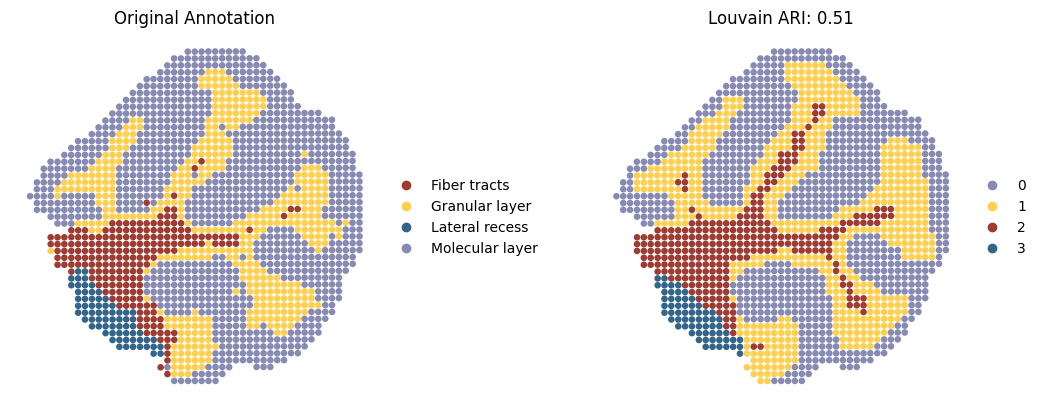

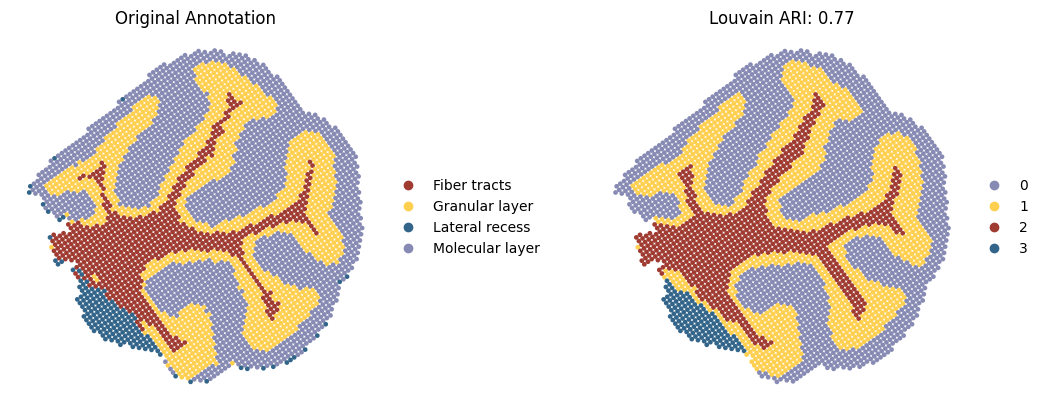

In [6]:
# spatial domain detection
adata1_leiden_result, adata1_louvain_result, adata1_mclust_result = metrics(adata1,
                                                                            save_loc='_slice1.png',
                                                                            n_neighbors=12,
                                                                            resolution=0.1,
                                                                            spot_size=0.02,
                                                                            cluster_label='Region',
                                                                            plot_color=["louvain", ],
                                                                            mclust_model='EEE',
                                                                            embed_label='fused_embedding',
                                                                            vis=False,
                                                                            save=False)

adata2_leiden_result, adata2_louvain_result, adata2_mclust_result = metrics(adata2,
                                                                            save_loc='_slice2.png',
                                                                            n_neighbors=15,
                                                                            resolution=0.1,
                                                                            spot_size=0.015,
                                                                            cluster_label='Region',
                                                                            plot_color=["louvain"],
                                                                            mclust_model='EEE',
                                                                            embed_label='fused_embedding',
                                                                            vis=False,
                                                                            save=False)

region_color = {'Fiber tracts': "#a03b32",
                'Granular layer': "#ffcf4f",
                'Lateral recess': "#33658A",
                'Molecular layer': "#878bb4",

                '0': "#878bb4",
                '1': "#ffcf4f",
                '2': "#a03b32",
                '3': "#33658A",
                1: "#89606a",
                2: "#71a2b6",
                }

sc.pl.spatial(adata1,
              img_key=None,
              color=["Region", "louvain"],
              spot_size=0.02,
              title=['Original Annotation', 'Louvain ARI: {:.2f}'.format(adata1_louvain_result['ARI'][0])],
              wspace=0.1,
              palette=region_color,
              frameon=False,
              save='_RNA_Metab_RNA.png'
              )

sc.pl.spatial(adata2,
              img_key=None,
              color=["Region", "louvain"],
              spot_size=0.015,
              title=['Original Annotation', 'Louvain ARI: {:.2f}'.format(adata2_louvain_result['ARI'][0])],
              wspace=0.1,
              palette=region_color,
              frameon=False,
              save='_RNA_Metab_Metab.png'
              )

## Modality bias correction

UMAP visualizations colored by ground truth annotation (left) and modalities (right), illustrating that the model preserves true biological differences while achieving effective integration.

/home/whcai/anaconda3/envs/PyG/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


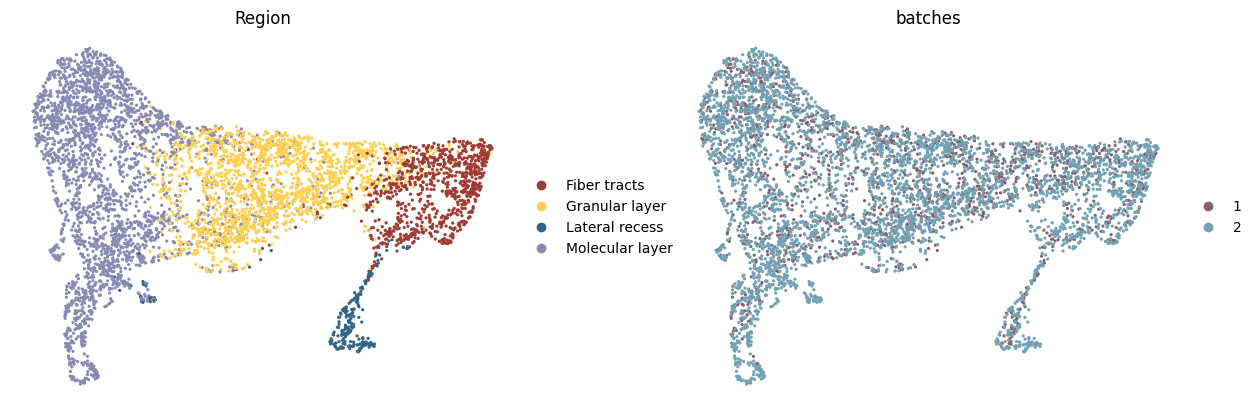

In [7]:
# modality bias correction (integration)
adata = sc.AnnData(X=np.concatenate([adata1.obsm['fused_embedding'], adata2.obsm['fused_embedding']]))
adata.obsm['spatial'] = np.concatenate([adata1.obsm['spatial'], adata2.obsm['spatial']])
adata.obs = pd.concat([adata1.obs, adata2.obs])
adata.obs['batches'] = adata.obs['batches'].astype('category')
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
sc.tl.umap(adata, min_dist=0.5, spread=1)
sc.pl.umap(adata,
           color=["Region", "batches"],
           wspace=0.2,
           palette=region_color,
           frameon=False,
           save='_RNA_Metab_check_batch.png')

## Show alignment

Alignment across slices, colored by region labels (300 alignment pairs shown for clarity)

dataset1: 4 cell types; dataset2: 4 cell types; 
                    Total :4 celltypes; Overlap: 4 cell types 
                    Not overlap :[[]]
Subsampled 300 pairs from 1844


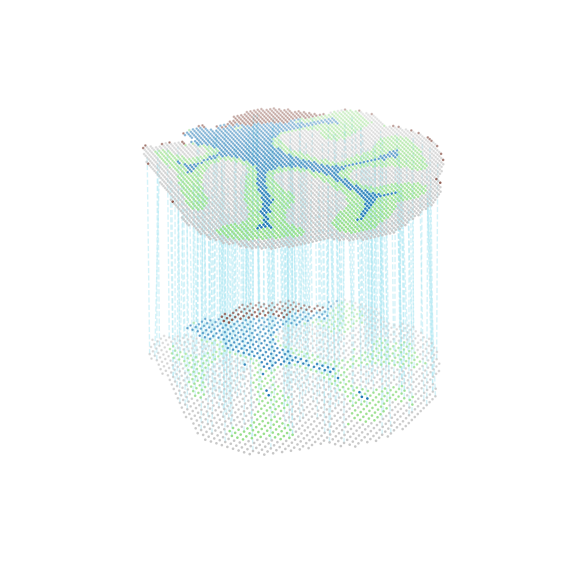

In [8]:
# show alignment
adata1_df = pd.DataFrame({'index': range(adata1.shape[0]),
                          'x': adata1.obsm['spatial'][:, 0],
                          'y': adata1.obsm['spatial'][:, 1],
                          'celltype': adata1.obs['Region']})
adata2_df = pd.DataFrame({'index': range(adata2.shape[0]),
                          'x': adata2.obsm['spatial'][:, 0],
                          'y': adata2.obsm['spatial'][:, 1],
                          'celltype': adata2.obs['Region']})
matching = np.array([trainer.match_in_adata1.data.cpu().numpy(), trainer.match_in_adata2.data.cpu().numpy()])
multi_align = match_3D_multi(adata1_df, adata2_df, matching, meta='celltype',
                             scale_coordinate=True, subsample_size=300, exchange_xy=False)
multi_align.draw_3D(target='all_type', size=[7, 8], line_width=1, point_size=[0.8, 0.8], line_color='blue',
                    hide_axis=True, show_error=False, only_show_correct=True, only_show_error=False,
                    line_alpha=0.5, save=None)

## Spots mapping accuracy
The all_matching function returns two plots:
1. A Sankey plot illustrating spots type correspondence based on alignments from SpatialFuser.
2. A histogram showing the similarity score distributions from random matching (bottom) and SpatialFuser matching (top) in pairwise alignments.


QC threshold：0.95%  -> 0.8087
valid matching ratio：100.0% (1677/1677)
spots mapping acc：74.90% (1256/1677)


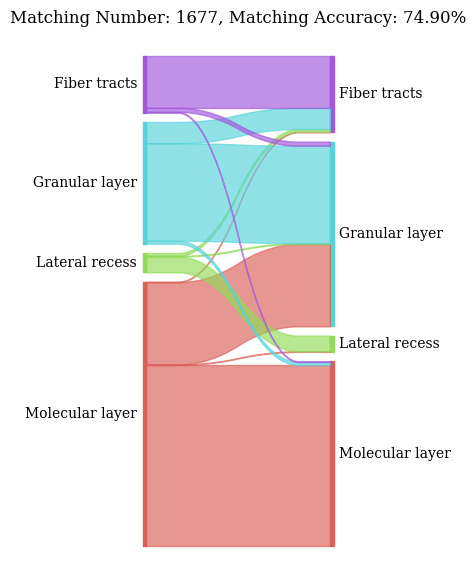

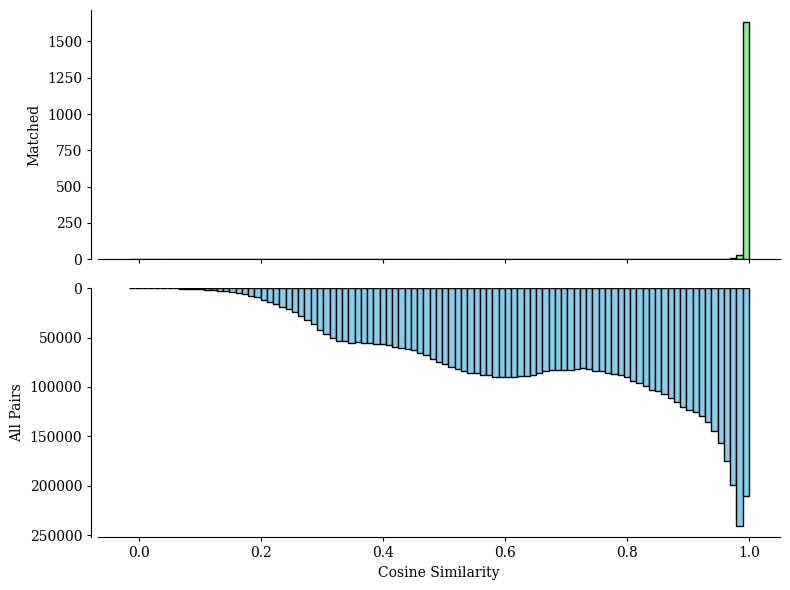

In [9]:
# evaluate alignment
valid_ratio, accuracy = all_matching(adata1, adata2,
                                     0.95,
                                     0.02,
                                     save_loc='./figures/',
                                     file_name='RNA_Metab')